In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
import zipfile
import os

# Upload the zip file
uploaded = files.upload()

# Assuming the zip file is named 'my_folder.zip'
zip_file_name = 'macau.zip'

# Unzip the file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('/content/')

# List the contents of the extracted folder
os.listdir('/content/')

Saving macau.zip to macau.zip


['.config',
 'README.md',
 'drive',
 'requirements.txt',
 'LICENSE.md',
 '__init__.py',
 'setup.py',
 'macau.zip',
 'macau',
 'demos',
 'sample_data']

In [4]:
from macau import MACAU

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [5]:
import numpy as np
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

import lightgbm
from macau.MACAU import MACAU

X, Y = make_moons(n_samples = 10000, noise = 0.2)
X = np.hstack([X, np.random.normal(0, 1, X.shape[0]).reshape(-1, 1)])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5)

In [6]:
lgbm_model = lightgbm.LGBMClassifier(boosting_type = 'rf',
                                     importance_type = 'gain',
                                     n_estimators = 100,
                                     max_depth = -1,
                                     colsample_bytree = 1.0,
                                     subsample_freq = 1,
                                     subsample = 0.1,
                                     reg_alpha = 0,
                                     reg_lambda = 0,
                                     verbose = -1,
                                     num_leaves = 31,
                                     min_child_samples = 20,
                                     n_jobs = 10)

lgbm_model.fit(X_train, Y_train)
macau = MACAU(lgbm_model).fit(X_train, Y_train)

In [7]:
x_grid, y_grid = np.meshgrid(np.linspace(1.25 * X.min(axis = 0)[0], 1.25 * X.max(axis = 0)[0], 100),
                             np.linspace(1.25 * X.min(axis = 0)[1], 1.25 * X.max(axis = 0)[1], 100))
grid_xy = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
grid_xy = np.hstack([grid_xy, np.random.normal(0, 1, grid_xy.shape[0]).reshape(-1, 1)])

# predict
pred = macau.predict(grid_xy)

# feature novelty probabilities
shap_novelty_contributors, shap_conditional_novelty_contributors = macau.novelty_explanations(grid_xy, shap_values = True)

# SCD
novelty_contributors, conditional_novelty_contributors = macau.novelty_explanations(grid_xy, shap_values = False)

In [8]:
grid_decision_surface = pred[:, 0].reshape((-1, 100)) # decision surface
grid_aleatoric_surface = pred[:, -3].reshape(-1, 100) # aleatoric uncertainty
grid_epistemic_surface = pred[:, -2].reshape(-1, 100) # epistemic uncertainty

grid_novelty_surface = pred[:, 2].reshape(-1, 100) # novelty surface

grid_shap_x_surface = shap_novelty_contributors[:, 0].reshape(-1, 100) # x-axis novelty surface
grid_shap_y_surface = shap_novelty_contributors[:, 1].reshape(-1, 100) # y-axis novelty surface
grid_shap_z_surface = shap_novelty_contributors[:, 2].reshape(-1, 100) # z-axis novelty surface

grid_contrib_x_surface = novelty_contributors[:, 0].reshape(-1, 100) # x-axis SCD surface
grid_contrib_y_surface = novelty_contributors[:, 1].reshape(-1, 100) # y-axis SCD surface
grid_contrib_z_surface = novelty_contributors[:, 2].reshape(-1, 100) # z-axis SCD surface

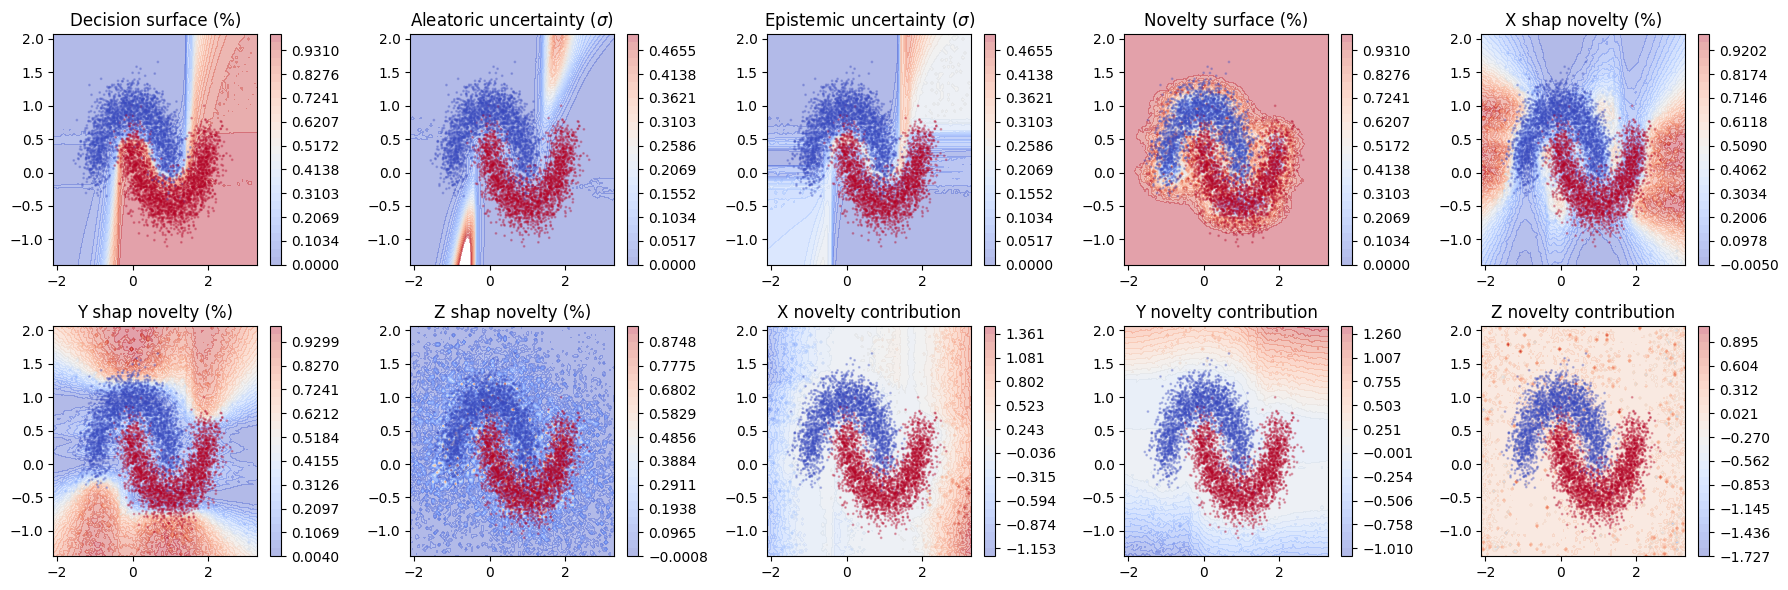

In [9]:

fig, ax = plt.subplots(figsize = (18, 6), ncols = 5, nrows = 2)
ax = ax.ravel()
ax[0].set_title('Decision surface (%)')
ax[1].set_title(r'Aleatoric uncertainty ($\sigma$)')
ax[2].set_title(r'Epistemic uncertainty ($\sigma$)')
ax[3].set_title('Novelty surface (%)')
ax[4].set_title('X shap novelty (%)')
ax[5].set_title('Y shap novelty (%)')
ax[6].set_title('Z shap novelty (%)')
ax[7].set_title('X novelty contribution')
ax[8].set_title('Y novelty contribution')
ax[9].set_title('Z novelty contribution')

for axis in ax:
    axis.set_xlim(grid_xy[:, 0].min(), grid_xy[:, 0].max())

contour = ax[0].contourf(x_grid, y_grid, grid_decision_surface, levels = np.linspace(0.0, 1.0, 30), vmin = 0.0, vmax = 1.0, alpha = 0.4, cmap = 'coolwarm')
ax[0].scatter(X_test[:, 0], X_test[:, 1], c = Y_test, cmap = 'coolwarm', s = 1, alpha = 0.3, label = 'samples')
fig.colorbar(contour, ax = ax[0])

contour = ax[1].contourf(x_grid, y_grid, grid_aleatoric_surface, levels = np.linspace(0.0, 0.5, 30), vmin = 0.0, vmax = 0.5, alpha = 0.4, cmap = 'coolwarm')
ax[1].scatter(X_test[:, 0], X_test[:, 1], c = Y_test, cmap = 'coolwarm', s = 1, alpha = 0.3, label = 'samples')
fig.colorbar(contour, ax = ax[1])

contour = ax[2].contourf(x_grid, y_grid, grid_epistemic_surface, levels = np.linspace(0.0, 0.5, 30), vmin = 0.0, vmax = 0.5, alpha = 0.4, cmap = 'coolwarm')
ax[2].scatter(X_test[:, 0], X_test[:, 1], c = Y_test, cmap = 'coolwarm', s = 1, alpha = 0.3, label = 'samples')
fig.colorbar(contour, ax = ax[2])

contour = ax[3].contourf(x_grid, y_grid, grid_novelty_surface, levels = np.linspace(0.0, 1.0, 30), vmin = 0.0, vmax = 1.0, alpha = 0.4, cmap = 'coolwarm')
ax[3].scatter(X_test[:, 0], X_test[:, 1], c = Y_test, cmap = 'coolwarm', s = 1, alpha = 0.3, label = 'samples')
fig.colorbar(contour, ax = ax[3])

contour = ax[4].contourf(x_grid, y_grid, grid_shap_x_surface, levels = np.linspace(grid_shap_x_surface.min(), grid_shap_x_surface.max(), 30), alpha = 0.4, cmap = 'coolwarm')
ax[4].scatter(X_test[:, 0], X_test[:, 1], c = Y_test, cmap = 'coolwarm', s = 1, alpha = 0.3, label = 'samples')
fig.colorbar(contour, ax = ax[4])

contour = ax[5].contourf(x_grid, y_grid, grid_shap_y_surface, levels = np.linspace(grid_shap_y_surface.min(), grid_shap_y_surface.max(), 30), alpha = 0.4, cmap = 'coolwarm')
ax[5].scatter(X_test[:, 0], X_test[:, 1], c = Y_test, cmap = 'coolwarm', s = 1, alpha = 0.3, label = 'samples')
fig.colorbar(contour, ax = ax[5])

contour = ax[6].contourf(x_grid, y_grid, grid_shap_z_surface, levels = np.linspace(grid_shap_z_surface.min(), grid_shap_z_surface.max(), 30), alpha = 0.4, cmap = 'coolwarm')
ax[6].scatter(X_test[:, 0], X_test[:, 1], c = Y_test, cmap = 'coolwarm', s = 1, alpha = 0.3, label = 'samples')
fig.colorbar(contour, ax = ax[6])

contour = ax[7].contourf(x_grid, y_grid, grid_contrib_x_surface, levels = np.linspace(grid_contrib_x_surface.min(), grid_contrib_x_surface.max(), 30), alpha = 0.4, cmap = 'coolwarm')
ax[7].scatter(X_test[:, 0], X_test[:, 1], c = Y_test, cmap = 'coolwarm', s = 1, alpha = 0.3, label = 'samples')
fig.colorbar(contour, ax = ax[7])

contour = ax[8].contourf(x_grid, y_grid, grid_contrib_y_surface, levels = np.linspace(grid_contrib_y_surface.min(), grid_contrib_y_surface.max(), 30), alpha = 0.4, cmap = 'coolwarm')
ax[8].scatter(X_test[:, 0], X_test[:, 1], c = Y_test, cmap = 'coolwarm', s = 1, alpha = 0.3, label = 'samples')
fig.colorbar(contour, ax = ax[8])

contour = ax[9].contourf(x_grid, y_grid, grid_contrib_z_surface, levels = np.linspace(grid_contrib_z_surface.min(), grid_contrib_z_surface.max(), 30), alpha = 0.4, cmap = 'coolwarm')
ax[9].scatter(X_test[:, 0], X_test[:, 1], c = Y_test, cmap = 'coolwarm', s = 1, alpha = 0.3, label = 'samples')
fig.colorbar(contour, ax = ax[9])

fig.tight_layout()


In [ ]:
X_train.shape

(5000, 3)